In [ ]:
%%capture
!pip install super-gradients==3.1.1
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2023-07-11 10:07:16] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-07-11 10:07:23] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-11 10:07:23] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-11 10:07:23] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-11 10:07:23] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-07-11 10:07:25] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with thes

  0%|          | 0.00/256M [00:00<?, ?B/s]

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
import zipfile

# Specify the path to the zip file
zip_path = '/content/crankshaft_yolo.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [ ]:
dataset_params = {
    'data_dir':'/content/crankshaft_yolo',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['crankshafts']
}

In [ ]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

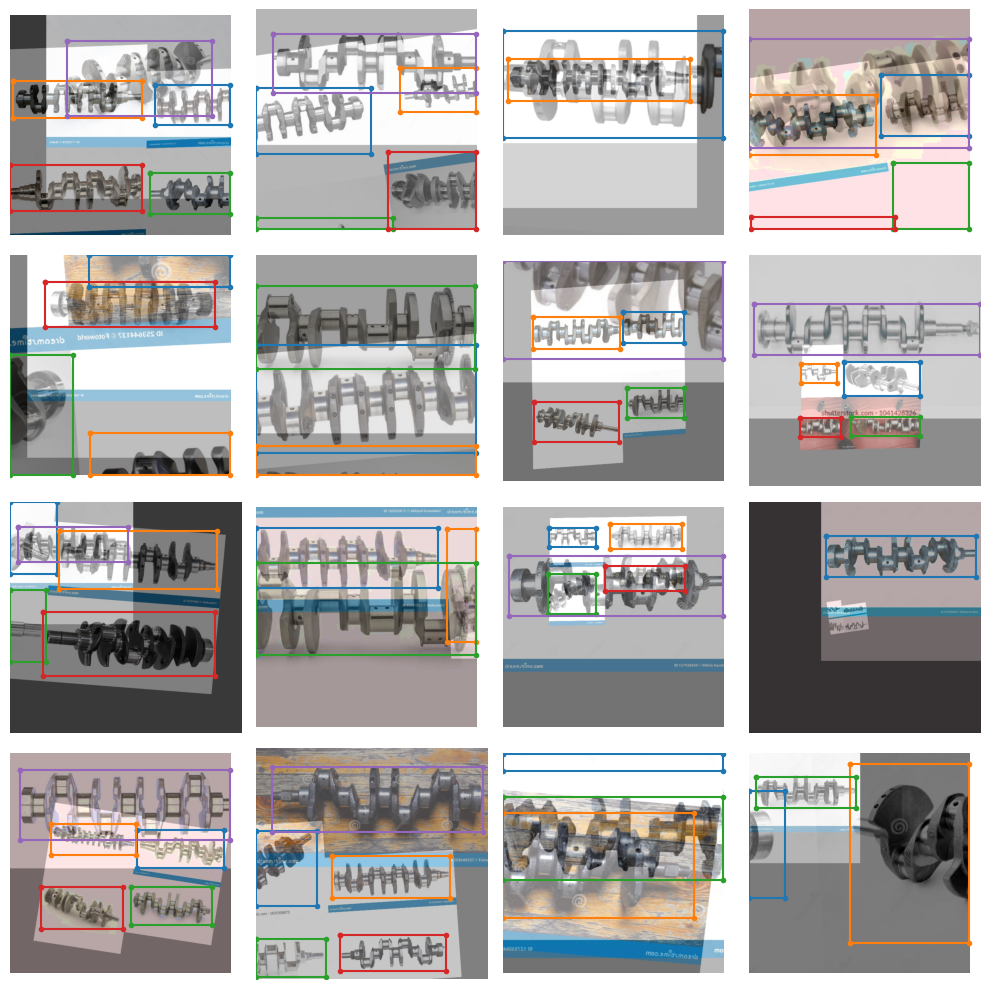

In [ ]:
train_data.dataset.plot()

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-07-07 05:32:07] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-07-07 05:57:49] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/console_Jul07_05_57_49.txt


[2023-07-07 05:57:55] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 43         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         2          (len(train_loader))
    - Gradient updates per epoch:   2          (len(train_loader) / batch_accumulate)

[2023-07-07 05:58:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-07-07 05:58:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0
[2023-07-07 06:35:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_fir

SUMMARY OF EPOCH 100
├── Training
│   ├── Ppyoloeloss/loss = 1.6305
│   │   ├── Best until now = 1.5092 (↗ 0.1212)
│   │   └── Epoch N-1      = 1.5092 (↗ 0.1212)
│   ├── Ppyoloeloss/loss_cls = 0.7635
│   │   ├── Best until now = 0.7257 (↗ 0.0379)
│   │   └── Epoch N-1      = 0.7307 (↗ 0.0329)
│   ├── Ppyoloeloss/loss_dfl = 1.0548
│   │   ├── Best until now = 0.9533 (↗ 0.1015)
│   │   └── Epoch N-1      = 0.9533 (↗ 0.1015)
│   └── Ppyoloeloss/loss_iou = 0.1358
│       ├── Best until now = 0.1208 (↗ 0.0151)
│       └── Epoch N-1      = 0.1208 (↗ 0.0151)
└── Validation
    ├── F1@0.50 = 0.0566
    │   ├── Best until now = 0.0835 (↘ -0.0269)
    │   └── Epoch N-1      = 0.0568 (↘ -0.0002)
    ├── Map@0.50 = 0.8967
    │   ├── Best until now = 0.9095 (↘ -0.0128)
    │   └── Epoch N-1      = 0.899  (↘ -0.0023)
    ├── Ppyoloeloss/loss = 1.8478
    │   ├── Best until now = 0.0    (↗ 1.8478)
    │   └── Epoch N-1      = 1.7161 (↗ 0.1317)
    ├── Ppyoloeloss/loss_cls = 0.9077
    │   ├── Best u

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

[2023-07-07 08:20:23] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yolonas_run/average_model.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

{'PPYoloELoss/loss_cls': 0.7773596,
 'PPYoloELoss/loss_iou': 0.104906,
 'PPYoloELoss/loss_dfl': 0.8844861,
 'PPYoloELoss/loss': 1.4818676,
 'Precision@0.50': tensor(0.0376),
 'Recall@0.50': tensor(1.),
 'mAP@0.50': tensor(0.8979),
 'F1@0.50': tensor(0.0724)}

Test: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


In [ ]:
img_url = 'https://thumbs.dreamstime.com/b/crankshaft-transmits-power-combustion-engine-52168758.jpg'
best_model.predict(img_url).show()

NameError: ignored